# Time series forecasting

## Dataset

此份筆記本會使用由 <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a> 所記錄的<a href="https://www.bgc-jena.mpg.de/wetter/" class="external">天氣時間資料集</a>來實作時間序列預測模型。

此份資料集包含 14 種不同的特徵，例如氣溫、大氣壓力和濕度。每 10 分鐘收集一次數據，全部資料含蓋由 2009 年至 2016 年之間收集的數據。

下面我們將實作幾組模型進行**每小時**的天氣**氣溫**預測。

Notebook 分成以下三個部分:
- EDA & Feature Engineering
- Data Windowing
- Models
    - Single-step Models: 預測**單個時間點**的數值
    - Multi-output Models: 預測**多個特徵**數值
    - Multi-step Models: 預測**多個時間點**的數值- EDA & Feature Engineering

## Importing Packages

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

資料集特徵除了 **Date Time** 之外還包含另外 14 種特徵

其說明可參照 <a href="https://www.bgc-jena.mpg.de/wetter/Weatherstation.pdf" class="external">Max Planck Institute for Biogeochemistry</a> 所提供之說明

<img src="https://i.imgur.com/hDrlewM.png" width="600">

In [3]:
df = pd.read_csv('jena_climate_2009_2016.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [4]:
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


In [5]:
# 由 Date Time 欄位可得知貢料為每 10 分鐘收集一筆
# 由於我們要進行預測的時間間隔是以「每小時」為單位
# 所以將資料以小時為單位做切片俿理
# [start:stop:step] 從第 5 篳資料開始，每經過 6 個時間記錄點取一次資料

df = df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [6]:
# 將 Date Time 欄位獨立取出，並將其中資料由 str 轉換為 datetime

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

## EDA & Feature Engineering

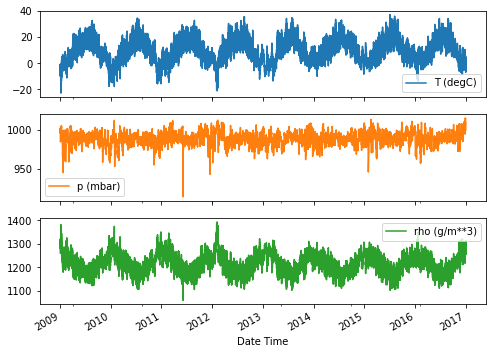

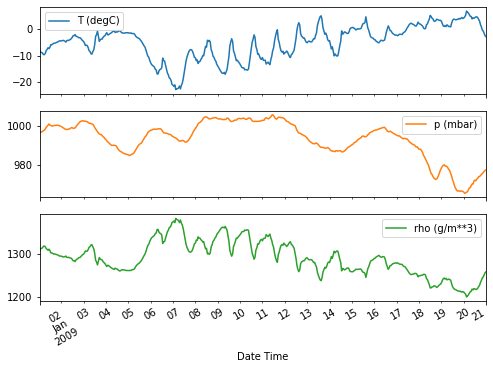

In [7]:
# 針對 'T (degC)', 'p (mbar)', 'rho (g/m**3)' 等特徵畫出它們的時間變化圖

# 2009~2016
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# 前 480 個小時(20 天)
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [8]:
# 查看每個特徵的敘述統計量

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


從以上的統計量描述可以發現 (`wv (m/s)`) 和 (`max. wv (m/s)`) 的 `min` 值為 `-9999` ，這樣的數值很有可能是錯的

另外透過 `wd(deg)` 風向這個欄位可判斷風速應該要大於或等於零 (`>=0`)，因此我們將 (`wv (m/s)`) 和 (`max. wv (m/s)`) 中的 `-9999` 代換為零:

In [9]:
# 將 'wv (m/s)' 中值等於 -9999.0 的值代換為 0.0
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

# 將 'max. wv (m/s)' 中值等於 -9999.0 的值代換為 0.0
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# 最後可再檢查代換後兩個特徵的最三值是否 >= 0.0
df['wv (m/s)'].min(), df['max. wv (m/s)'].min()

(0.0, 0.0)

### Wind

Text(0, 0.5, 'Wind Velocity [m/s]')

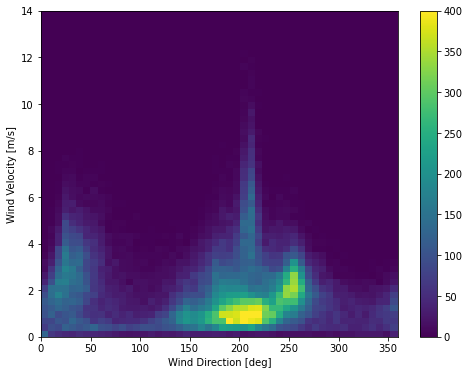

In [10]:
# 畫出 'wd (deg)' 與 'wv (m/s)' 的 2D 直方圖

plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

風向 `wd (deg)` 採 0°~360° 為記錄資料。這樣的記錄方式對模型來說不是一件好事，因為 360° 與  0° 彼此應該是靠近且平滑連接的。

我們可以利用「風向」和「風速」轉換出風向量的「x分量」與「y分量」

<img src="https://i.imgur.com/w3bZcUP.png" width="300">

In [11]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# 將角度由度度量轉換為弧度度量
wd_rad = df.pop('wd (deg)')*np.pi / 180

# 計算風的「x分量」與「y分量」 
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# 計算最大風的「x分量」與「y分量」
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

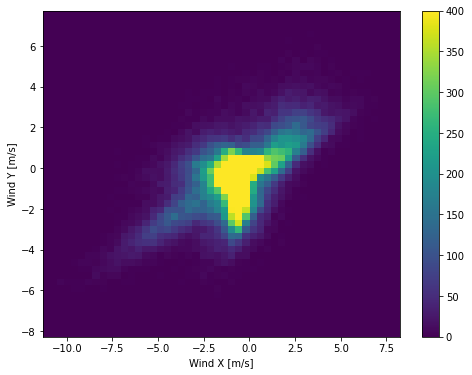

In [12]:
# 畫出 'Wx', 'Wy' 的 2D 直方圖

plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

### Time

天氣類型的數據可能會與一天當中的時間或是一年當中的時間週期有相關性。

我們可以通過使用 sine / cosine transform 將「一天的時間」資訊和「一年的時間」資訊編碼起來形成時間資料。

In [13]:
# 將 data_time 中的「日期時間」資料轉換成「秒(float)」(ex: 2009-01-01 01:00:00 ---> 1230771600.0)
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# 分別計算一天與一年之秒數
day = 24*60*60
year = (365.2425)*day

# 分別進行一天與一年為週期的 sine / cosine 轉換
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

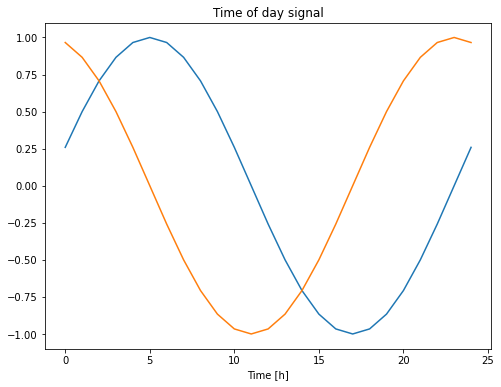

In [14]:
# 畫出一天 (24小時之內) 的時間變化
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

### Split the data

將資料以 `(70%, 20%, 10%)` 的比例切分成「訓練」、「驗證」與「測試」集。

要特別注意，在切分前勿將資料打亂，以避免後續在取 window 時喪失時間相關性。

In [15]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Data Normalization

In [16]:
# 計算訓練集各特徵的平均數與標準差
train_mean = train_df.mean()
train_std = train_df.std()

# 分別對訓練、驗證、測試資料做 normalization
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

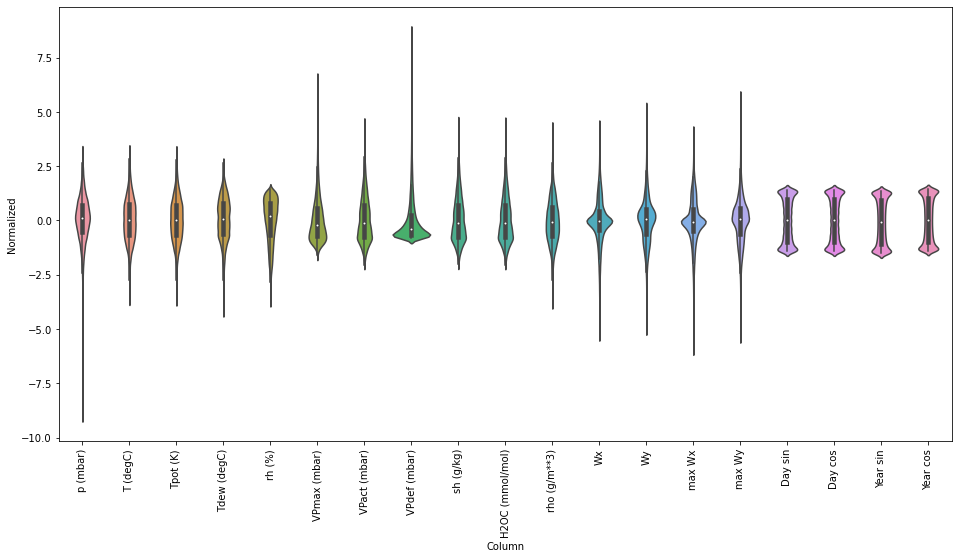

In [17]:
# 進行完 normalization 後，可觀察各個特徵的數值分佈

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized') # 將 df_std DataFrame 從 wide format 轉成 long format 

plt.figure(figsize=(16, 8))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

對 DataFrame 中的資料依照時序進行窗口採樣 (Windowing)

對於 input windows 而言，以下三個特性是應當考慮到的:

- input windows 和 lable windows 的時間長度（number of time steps）
- input windows 和 lable windows 的時間差 (time offset)
- 哪些 feature 被用作輸入、標籤或兩者都是 

我們可依據任務與使用的模型產生不同的 windows，以下是幾個例子:

1. 如果我們要利用 24 小時的歷史資料來預測 24 小時後的天氣狀態，我們取 window 的方式應該如下:

<img src="https://i.imgur.com/LQmCJWk.png">

2. 如果我們要利用 6 小時的歷史資料來預測未來 1 小時的天氣狀態，我們取 window 的方式應該如下:

<img src="https://i.imgur.com/zseRyiv.png">

接下來我們定義了一個 `WindowGenerator` 類。這個類能夠：

1. 處理上方圖表中所示的索引(`indexes`)和時間偏移量(`offsets`)。
2. 將 `windows` 分成 `(inputs, labels)` 對。
3. 繪製 `windows` 的內容。
4. 使用 `tf.data.Dataset` 從訓練、評估和測試數據中高效地生成這些窗口的批次。

### 1. Indexes and offsets

`WindowGenerator` 類中的 `__init__` 方法包含了 `input` 和 `label` 的**索引**所需的所有邏輯。

`WindowGenerator` 還接受訓練、驗證和測試集的 `DataFrame` 作為輸入。這些稍後將被轉換為 `windows` 的 `tf.data.Dataset`

In [18]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # 存入原始數據
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # 將要預測的 label column 做索引編號
        # 如果 label_columns == None 則將 train_df 中的所有 columns 作索引編號
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # 進行 windows 的參數設定
        self.input_width = input_width                                                 # 設定 input window 長度
        self.label_width = label_width                                                 # 說定 label window 長度
        self.shift = shift                                                             # 設定 time offset 長度

        self.total_window_size = input_width + shift

        # slice(start, end, step): 返回一個 slice 物件，用於指定如何對一個 sequence 做切片
        self.input_slice = slice(0, input_width)                                       # 切分 input window 索引位置的切片對象
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width                   # label window 的起始位置
        self.labels_slice = slice(self.label_start, None)                              # 切分 label window 索引位置的切片對象
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    # 定義 WindowGenerator() 物件的表現形式，如此可以方便知道一個 WindowGenerator() 物件的相關資訊
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

下面我們創建兩 `WindowGenerator` 物件，分別對應到上面兩張 windows 的圖

In [19]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [20]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split

將 `windows` 分成 `(inputs, labels)` 對。

<img src="https://i.imgur.com/ou4R3SI.png">

In [21]:
def split_window(self, windows):
    # 定義將 windows 分解成 input_windows 與 label_windows 的方法
    # windows 的 shape 分別表示 (batch, time, features)
    
    input_windows = windows[:, self.input_slice, :]
    label_windows = windows[:, self.labels_slice, :]
    
    # 挑選出有指定做為 label 的特徵
    if self.label_columns is not None:
        label_windows = tf.stack(
            [label_windows[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # 做完切片後檢查一次 input_windows 和 label_windows 的 time shape 是否與設定的 input_width 與 label_width 一致
    input_windows.set_shape([None, self.input_width, None])
    label_windows.set_shape([None, self.label_width, None])

    return input_windows, label_windows

# 將 split_window 賦值給 WindowGenerator.split_window
WindowGenerator.split_window = split_window

In [22]:
# 將 3 個切片疊在一起，其時間長度為 total_window_size
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


2023-03-30 10:52:49.103307: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 10:52:49.765760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0e:00.0, compute capability: 6.1


### 3. Plot

針對 `input_windows`, `label_windows`, `模型預測` 視覺化內容

In [23]:
# 先將上面 example_inputs 和 example_labels 賦值給 w2.example
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example           # 給定 batch size 個時間區段的 inputs 和 labels
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))  # 設定 subplots 的數量
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        
        # 畫出 Plot_col 的 input 資料
        # zorder 控制繪圖的順序，數值愈大愈晚畫上表示會在圖的愈上層
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        # 畫出 plot_col 的 label 資料
        plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            
            # 畫出模型的預測結果
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],marker='X', 
                        edgecolors='k', label='Predictions',c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

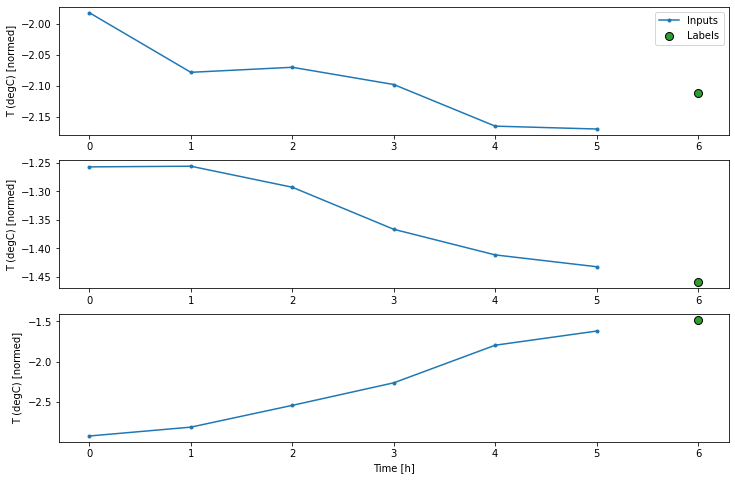

In [25]:
w2.plot()

也可以選其它的 column 來畫資料點，不過 `w2` 在創建時僅設定了 label 為 `T (degC)` 所以圖中只會呈現 `input_windows` 的資料

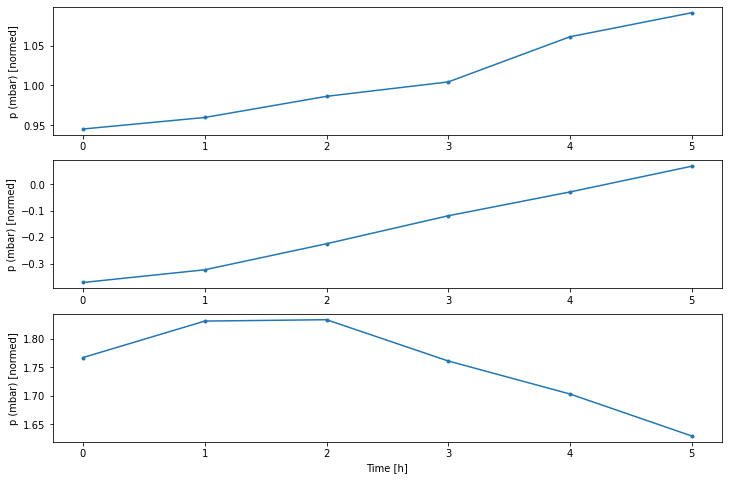

In [26]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

下面的 `make_dataset` 方法會接收時間序列 DataFrame 並將其轉換為 `tf.data.Dataset` of `(input_window, label_window)`

使用 `tf.keras.utils.timeseries_dataset_from_array` 會返回 `tf.data.Dataset` 物件，它會輸出 `(input_window, label_window)`

In [27]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` 對象保存了訓練、驗證和測試數據。 

使用之前定義的 `make_dataset` 方法添加屬性以將它們作為 `tf.data.Datasets` 訪問。此外，添加一個標準示例批次以便於訪問和繪圖。

In [28]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    # 獲取並緩存一批用於繪圖的 “inputs 和 labels 示例
    
    # getattr() 函数用於返回一个對象的属性值，此處用以返回 `_example` 屬性
    result = getattr(self, '_example', None)
    if result is None:
        
        # 未找到示例批次，因此從 `.train` 數據集中獲取一個
        result = next(iter(self.train))
        
        # 並緩存以備下次使用
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

現在，`WindowGenerator` 對象可以訪問 `tf.data.Dataset` 對象，因此我們可以輕鬆地迭代數據

`Dataset.element_spec` 屬性告訴您數據集元素的結構、數據類型和形狀

In [29]:
# 每個元素都是一個（input，label）序對
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

我們可以從 `Dataset` 中迭代出具體的批次

In [30]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Models

### Single-step Models

僅根據當前條件預測未來 1 個時間步長（一小時）的值

下面我們以預測**單個特徵** `T (degC)` 的值為例作為說明

若是要以 RNN 設計 single-step models , 則設計方式可分為兩種 `Many-to-one` 和 `Many-to-many`:

#### Many-to-one

其中一種是 RNN 僅返回最後一個時間步的輸出，讓模型有時間在進行單個預測之前預熱其內部狀態, 如下圖:

<img src="https://i.imgur.com/KBbPdgK.png">

要使用此種作法須將 Keras RNN layer 中的 `return_sequences` 參數設為 `False`

In [31]:
window_1h = WindowGenerator(
    input_width=24, label_width=1, shift=1,
    label_columns=['T (degC)'])

window_1h

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['T (degC)']

In [32]:
lstm_model_1h = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False, input_shape=(24, 19)),
    # Shape => [batch, dense_units]
    tf.keras.layers.Dense(units=1),
    # Shape => [batch, 1, features](使 model prediction shape 與 label shape 一致)
    tf.keras.layers.Reshape([1, -1])
])

lstm_model_1h.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                6656      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
 reshape (Reshape)           (None, 1, 1)              0         
                                                                 
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [33]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [34]:
print('Input shape:', window_1h.example[0].shape)
print('Output shape:', lstm_model_1h(window_1h.example[0]).shape)

Input shape: (32, 24, 19)


2023-03-30 10:52:51.566025: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


Output shape: (32, 1, 1)


In [35]:
history = compile_and_fit(lstm_model_1h, window_1h)

IPython.display.clear_output()

# tf.keras.Model.evaluate => (loss value, metrics values)
print('Val MAE:', lstm_model_1h.evaluate(window_1h.val, verbose=0)[1])
print('Test MAE:', lstm_model_1h.evaluate(window_1h.test, verbose=0)[1])

Val MAE: 0.050892941653728485
Test MAE: 0.05144056677818298


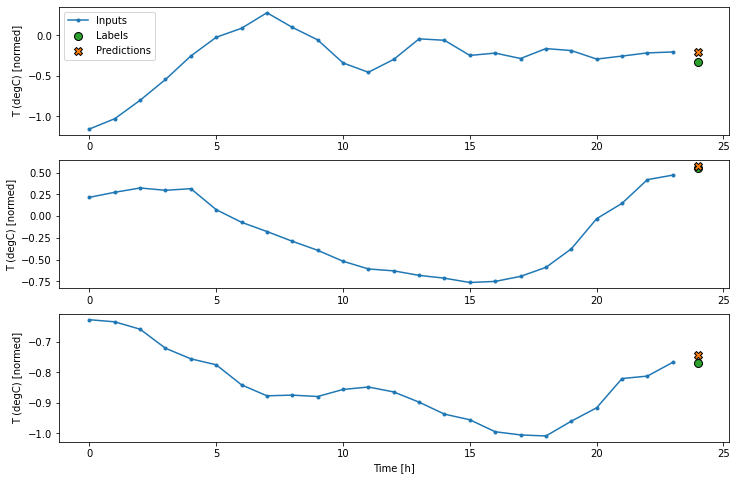

In [36]:
window_1h.plot(lstm_model_1h)

#### Many-to-many

另外一種使用 RNN 設計 single-step models 的方式為讓 RNN 為每個輸入返回一個輸出，如下圖:

<img src="https://i.imgur.com/iJ5Q1a7.png">

要使用此種作法須將 Keras RNN layer 中的 `return_sequences` 參數設為 `True`

In [37]:
window_24h = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

window_24h

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [38]:
lstm_model_24h = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(24, 19)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

lstm_model_24h.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 32)            6656      
                                                                 
 dense_1 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [39]:
print('Input shape:', window_24h.example[0].shape)
print('Output shape:', lstm_model_24h(window_24h.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [40]:
history = compile_and_fit(lstm_model_24h, window_24h)

IPython.display.clear_output()

# tf.keras.Model.evaluate => (loss value, metrics values)
print('Val MAE:', lstm_model_24h.evaluate(window_24h.val, verbose=0)[1])
print('Test MAE:', lstm_model_24h.evaluate(window_24h.test, verbose=0)[1])

Val MAE: 0.05151371657848358
Test MAE: 0.05220181494951248


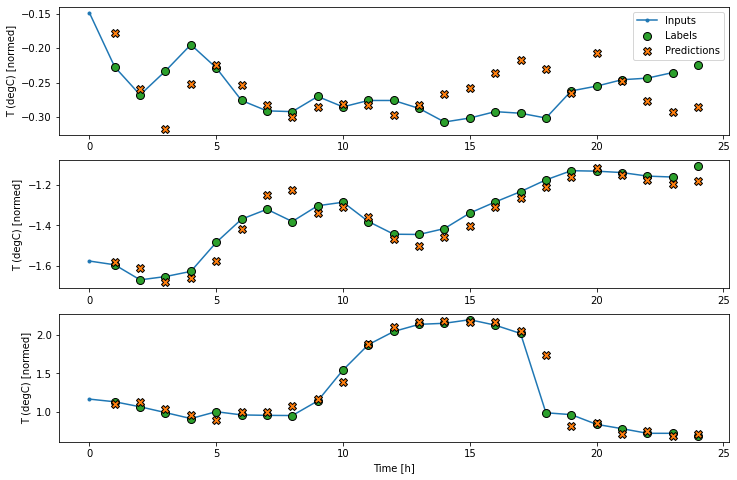

In [41]:
window_24h.plot(lstm_model_24h)

### Multi-output models

目前為止，以上模型都預測了**單個時間步長**的**單個輸出特徵** `T (degC)`

所有這些模型都可以轉換為預測**多個特徵**，只需更改輸出層中的單元數並調整 training windows 讓其包含標籤中的所有特徵

In [42]:
multi_output_window_24h = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in multi_output_window_24h.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


In [43]:
multi_output_lstm_model_24h = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

In [44]:
history = compile_and_fit(multi_output_lstm_model_24h, multi_output_window_24h)

IPython.display.clear_output()
print('Val MAE:', multi_output_lstm_model_24h.evaluate( multi_output_window_24h.val, verbose=0)[1])
print('Test MAE:', multi_output_lstm_model_24h.evaluate( multi_output_window_24h.test, verbose=0)[1])

Val MAE: 0.1209387332201004
Test MAE: 0.122310109436512


#### Residual connections

我們也可以設計殘差結構，讓模型預測下個時間點的變化量而非預測下個時間點的數值，這也是時間序列中常見的作法

<img src="https://i.imgur.com/1fwwTBC.png">

In [45]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [46]:
multi_output_residual_lstm_24h = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

In [47]:
history = compile_and_fit(multi_output_residual_lstm_24h, multi_output_window_24h)

IPython.display.clear_output()
print('Val MAE:', multi_output_residual_lstm_24h.evaluate(multi_output_window_24h.val, verbose=0)[1])
print('Test MAE:', multi_output_residual_lstm_24h.evaluate( multi_output_window_24h.test, verbose=0)[1])

Val MAE: 0.1185312420129776
Test MAE: 0.12004580348730087


### Multi-step models

前面做的模型不論做的是 single-output models 還是 multi-output models 所作的都是 **single-step models** <br>
也就是模型做的預測是**未來一個時間步長**的值 <br>
接下來將著眼於如何擴展這些模型以進行**多時間步長**預測

In [48]:
OUT_STEPS = 24
multi_step_window_24h = WindowGenerator(input_width=24, 
                                        label_width=OUT_STEPS, 
                                        shift=OUT_STEPS, 
                                        label_columns=['T (degC)'])

multi_step_window_24h

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['T (degC)']

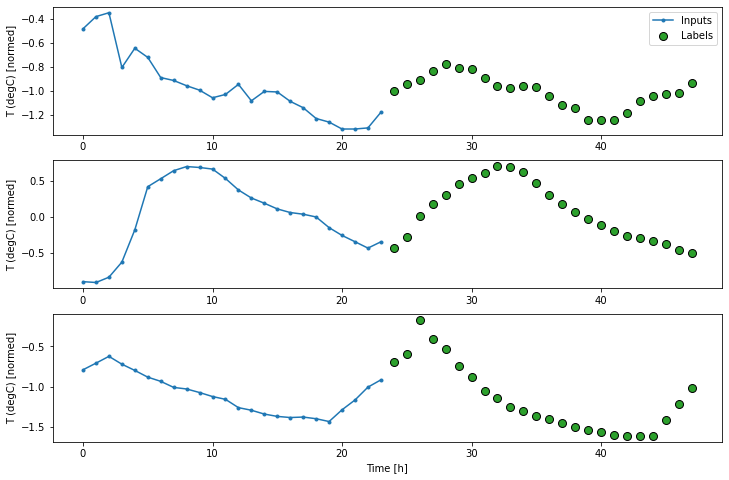

In [49]:
multi_step_window_24h.plot()

#### RNN

RNN 可以學習使用長期的歷史輸入。模型會累積 24 小時的 internal state，然後再對接下來的 24 小時進行單一預測 <br>
在這種單次格式中，LSTM 只需要在最後一個時間步產生一個輸出，所以在 `tf.keras.layers.LSTM` 中設置 `return_sequences=False`

<img src="https://i.imgur.com/vCFIkc2.png">

In [50]:
multi_step_lstm_model_24h = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [51]:
history = compile_and_fit(multi_step_lstm_model_24h, multi_step_window_24h)

IPython.display.clear_output()
print('Val MAE:', multi_step_lstm_model_24h.evaluate(multi_step_window_24h.val, verbose=0)[1])
print('Test MAE:', multi_step_lstm_model_24h.evaluate(multi_step_window_24h.test, verbose=0)[1])

Val MAE: 0.2050347626209259
Test MAE: 0.18745076656341553


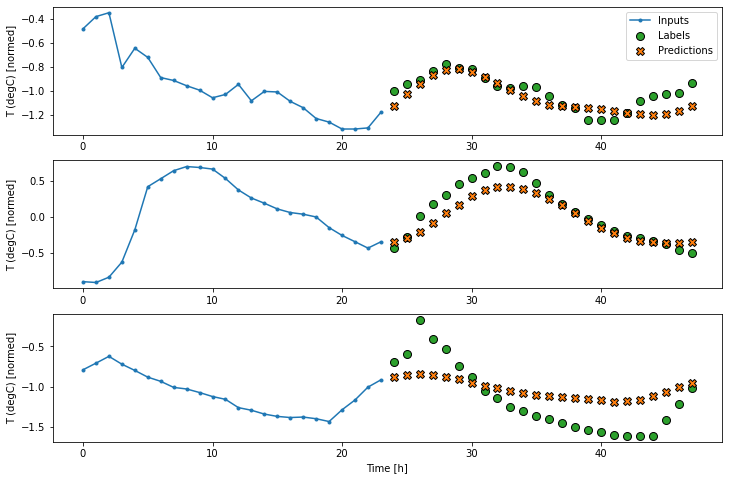

In [52]:
multi_step_window_24h.plot(multi_step_lstm_model_24h)

#### Autoregressive model
構建 Autoregressive RNN 模型，模型從 `OUT_STEPS` 開始進行後面每個時間點的預測，每一步模型會參考前一步的預測再生成下一步的預測<br>
由於自迴歸的機制在 `tf.keras.layers.LSTM` 並沒有支援，這樣的機制要從較低級別的 `tf.keras.layers.LSTMCell` 進行單時間步運作的設計與管理

<img src="https://i.imgur.com/vXXugBd.png">

In [53]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [54]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [55]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [56]:
prediction, state = feedback_model.warmup(multi_step_window_24h.example[0])
prediction.shape

TensorShape([32, 19])

In [57]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [58]:
print('Output shape (batch, time, features): ', feedback_model(multi_step_window_24h.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


In [59]:
history = compile_and_fit(feedback_model, multi_step_window_24h)

IPython.display.clear_output()
print('Val MAE:', feedback_model.evaluate(multi_step_window_24h.val, verbose=0)[1])
print('Test MAE:', feedback_model.evaluate(multi_step_window_24h.test, verbose=0)[1])

Val MAE: 0.2290627509355545
Test MAE: 0.20209167897701263


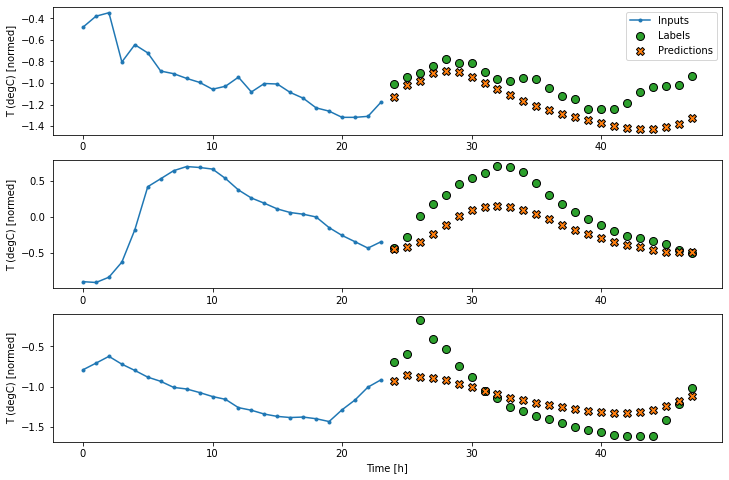

In [60]:
multi_step_window_24h.plot(feedback_model)

## References

<a href="https://www.tensorflow.org/tutorials/structured_data/time_series#setup" class="external">TensorFlow 官網 Time Series Forcasting</a>.